In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Greenland = pd.read_excel(filepath, sheet_name='Greenland-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Greenland)
fp.date_time(Greenland)

,Extent,Date
0,1076123.146,1979-01-01
1,1099248.063,1979-02-01
2,1036964.901,1979-03-01
3,958927.937,1979-04-01
4,823812.694,1979-05-01
...,...,...
533,721350.515,2023-06-01
534,459033.164,2023-07-01
535,282045.909,2023-08-01
536,270397.608,2023-09-01


In [5]:
scaler = MinMaxScaler()
Greenland['Extent'] = scaler.fit_transform(Greenland['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 10
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Greenland['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((517, 12, 1), (517,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Greenland_LT10/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 39s 496ms/step - loss: 0.2332 - root_mean_squared_error: 0.4829 - val_loss: 0.0551 - val_root_mean_squared_error: 0.2348
Epoch 2/50
53/53 [==============================] - 22s 427ms/step - loss: 0.0525 - root_mean_squared_error: 0.2292 - val_loss: 0.0280 - val_root_mean_squared_error: 0.1672
Epoch 3/50
53/53 [==============================] - 22s 419ms/step - loss: 0.0383 - root_mean_squared_error: 0.1956 - val_loss: 0.0254 - val_root_mean_squared_error: 0.1593
Epoch 4/50
53/53 [==============================] - 21s 411ms/step - loss: 0.0342 - root_mean_squared_error: 0.1849 - val_loss: 0.0246 - val_root_mean_squared_error: 0.1568
Epoch 5/50
53/53 [==============================] - 21s 407ms/step - loss: 0.0279 - root_mean_squared_error: 0.1669 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1424
Epoch 6/50
53/53 [==============================] - 22s 429ms/step - loss: 0.0226 - root_mean_squared_error: 0.1504 - val_loss: 0.0179 

53/53 [==============================] - 2s 44ms/step - loss: 0.0113 - root_mean_squared_error: 0.1064 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1242
Epoch 36/50
53/53 [==============================] - 2s 44ms/step - loss: 0.0111 - root_mean_squared_error: 0.1054 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1178
Epoch 37/50
53/53 [==============================] - 4s 77ms/step - loss: 0.0114 - root_mean_squared_error: 0.1067 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1206
Epoch 38/50
53/53 [==============================] - 3s 51ms/step - loss: 0.0114 - root_mean_squared_error: 0.1066 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1339
Epoch 39/50
53/53 [==============================] - 4s 70ms/step - loss: 0.0113 - root_mean_squared_error: 0.1061 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1153
Epoch 40/50
53/53 [==============================] - 17s 324ms/step - loss: 0.0109 - root_mean_squared_error: 0.1042 - val_loss: 0.0106 - val_root_mean_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

8.06564926703771 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

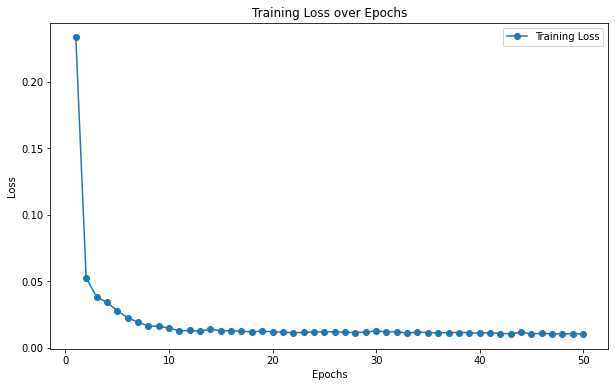

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

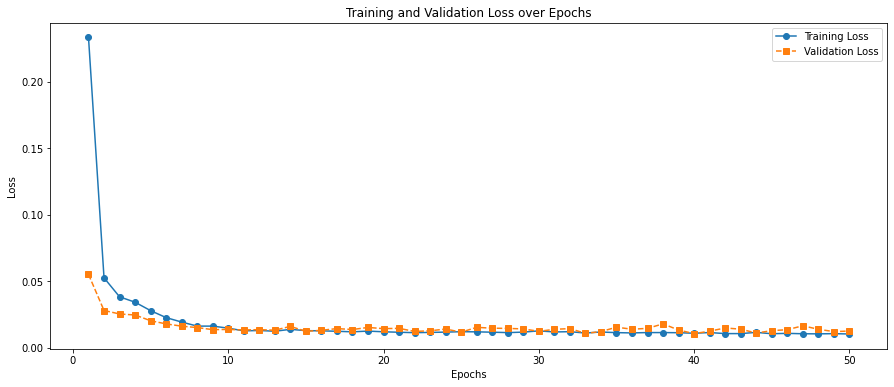

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Greenland_LT10/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 16ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.09360371134177047
MAE : 0.07227344294557271


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,680042.87500,641562.292
1,702046.81250,734946.437
2,695472.18750,777596.225
3,634903.00000,687087.673
4,534058.31250,622337.816
5,423714.50000,467232.074
6,355278.93750,297495.641
7,342406.68750,268909.854
8,394541.59375,408072.791
9,469031.43750,552314.148


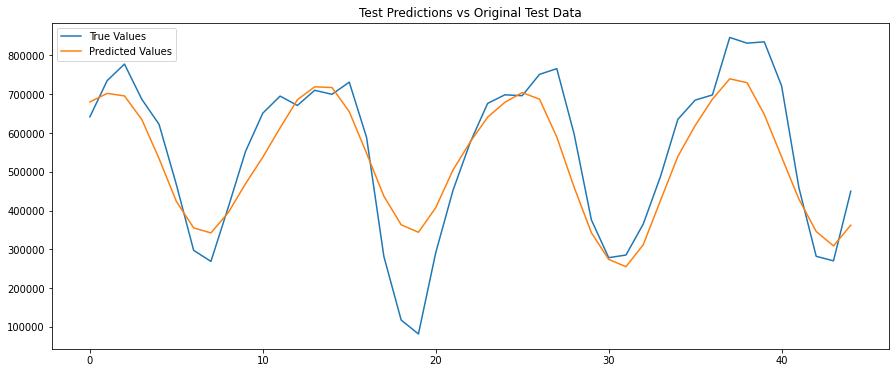

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 24ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

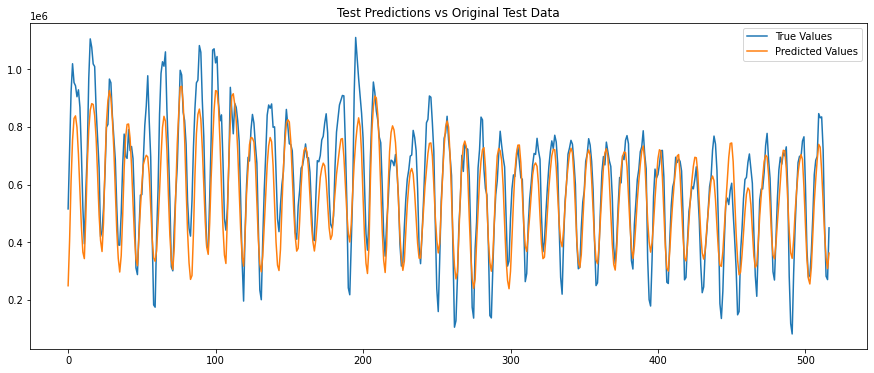

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()